Lectura y expansión de la señal x[n]

In [6]:
import numpy as np
import soundfile as sf
from scipy.fft import dct, idct
import matplotlib.pyplot as plt
import sounddevice as sd


def leer_y_expandir(wavfile, N=64):
    """
    Lee el WAV, retorna (xE, fs).
    xE es la señal expandida, su longitud es múltiplo de N.

    Steps:
    1. Leer el archivo WAV.
    2. Completar con ceros para que la longitud sea múltiplo de N.
    3. Retornar la señal expandida y la frecuencia de muestreo.
    """
    x, fs = sf.read(wavfile)  # x en range [-1,1] si es float

    # Calculamos número de ceros para completar múltiplo de N:
    resto = len(x) % N
    print(x.shape)

    if resto == 0:
        xE = x
    else:
        ceros = np.zeros(N - resto, dtype=x.dtype)
        xE = np.concatenate((x, ceros))

    return xE, fs

Cálculo vectorizado de DCT por bloques

In [7]:
"""
xE es un array 1D de longitud multiple de N.
Retorna una matriz C de forma (N, Nb),
donde Nb = numero de bloques = len(xE)/N,
y C[:,b] es la DCT( xE[b*N : b*N+N] ).

Steps:
1. Reformar xE a (N, Nb).
2. Calcular la Tranformada Discreta de Coseno a lo largo de cada columna (bloque) - axis=0.
"""

# Tamaño (N, Nb) si reshape(-1,N)
# Calculamos la DCT a lo largo de la dimensión 0 (cada columna un bloque)
# Por convención, la DCT de scipy actúa a lo largo del eje=0 si no se especifica:
#   dct(x, axis=0) => transformada por filas,
# pero ahora nuestras "filas" son en realidad muestras del bloque,
# y nuestras "columnas" son distintos bloques.


def dct_bloques(xE, N=64):

    xE_2d = xE.reshape(-1, N).T  # (N, Nb)
    C = dct(xE_2d, axis=0, norm="ortho")
    return C


def idct_bloques(C):

    X_2d = idct(C, axis=0, norm="ortho")
    X_1d = X_2d.T.reshape(-1)  # quita la transposición y "aplanado"
    return X_1d

Cálculo de la compacción (ganancia G)

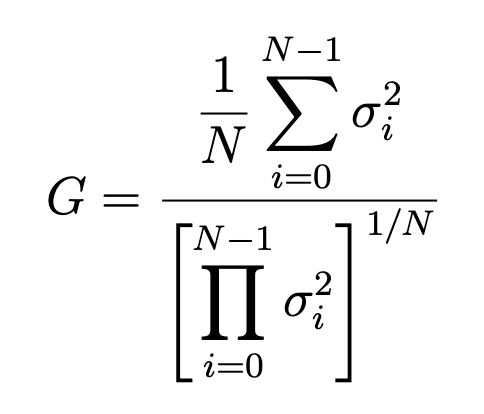
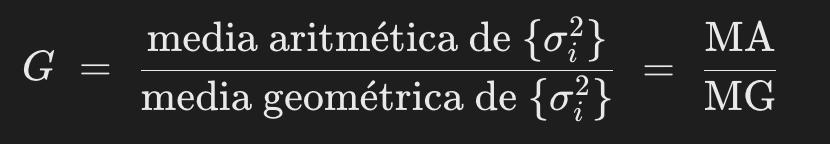

In [8]:
# # X_blocks es (N, Nb):
# #  la fila i corresponde a "todas las realizaciones de la variable aleatoria X_i"
# vars_X = np.var(X_blocks, axis=1, ddof=1)  # ddof=1 => var muestral

# vars_C = np.var(C_blocks, axis=1, ddof=1)


def ganancia_compactacion(array):

    media_aritmetica = np.mean(array)

    vars_pos = np.clip(
        array, 1e-15, None
    )  # hace que los valores menores a 1e-15 sean 1e-15 y los mayores a 1e-15 se mantengan

    media_geometrica = np.exp(
        np.mean(np.log(vars_pos))
    )  # exponecial de la media de los logaritmos

    return media_aritmetica / media_geometrica


def calcular_ganancias(X_blocks, C_blocks):
    varianza_X = np.var(X_blocks, axis=1, ddof=1)
    varianza_C = np.var(C_blocks, axis=1, ddof=1)
    GX = ganancia_compactacion(varianza_X)
    GC = ganancia_compactacion(varianza_C)
    return GX, GC

Filtrado de altas frecuencias

In [9]:
def filtrar_altas_freq(C, M):
    """
    Pone a cero los coeficientes de indice >= M en cada columna.
    C es (N, Nb).
    Retorna la matriz Cfiltrada (mismo shape).
    """
    C_filtr = C.copy()
    C_filtr[M:, :] = 0
    return C_filtr

Ejemplo:

(65226,)
Ganancia en X = 1.0019, Ganancia en C = 19.7782
Reproduciendo señal filtrada...
SNR(dB) = 12.70


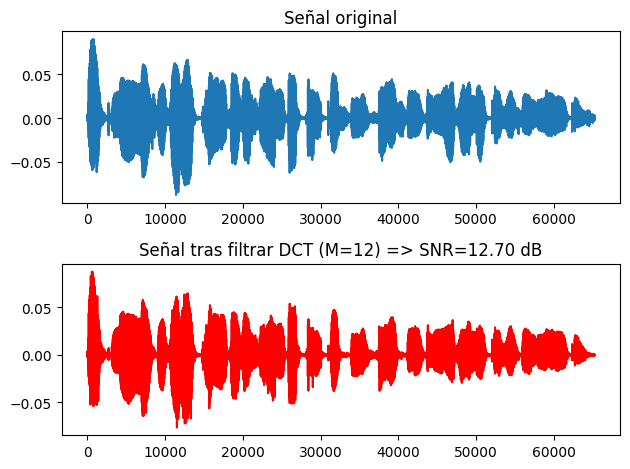

In [12]:
def practica5_ejemplo(wavfile="../data/v1.wav", N=64, M=48):
    """
    1) Lee v1.wav (mono), expande a multiplo de N.
    2) Forma una matriz (N x Nb) con xE.
    3) Calcula la DCT(64) de todos los bloques (matriz C).
    4) Calcula la ganancia en X y en C (compacción)
    5) Elimina (pone a 0) los coeficientes con indice >= M.
    6) IDCT para recuperar yE.
    7) Recorta ceros y escucha la señal final.
    8) Muestra la relacion señal-a-ruido o el espectro, etc.
    """

    # 1) Leer y expandir
    xE, fs = leer_y_expandir(wavfile, N)
    L_original = len(
        sf.read(wavfile)[0]
    )  # para saber cuantas muestras tenía sin expandir

    # 2) Matriz X_blocks = (N, Nb)
    X_blocks = xE.reshape(-1, N).T  # (N, Nb)

    # 3) DCT
    C_blocks = dct(X_blocks, axis=0, norm="ortho")  # (N, Nb)

    # 4) Ganancias
    GX, GC = calcular_ganancias(X_blocks, C_blocks)
    print(f"Ganancia en X = {GX:.4f}, Ganancia en C = {GC:.4f}")

    # 5) Filtrar altas freq
    C_filtr = filtrar_altas_freq(C_blocks, M)

    # 6) IDCT
    yE_2d = idct(C_filtr, axis=0, norm="ortho")  # (N, Nb)
    yE = yE_2d.T.reshape(-1)

    # Recortar ceros al final
    y = yE[:L_original]

    # 7) Escuchar (si deseas)

    print("Reproduciendo señal filtrada...")
    sd.play(y, fs)
    sd.wait()

    # 8) Métrica SNR:
    #   Tomar x (original) y la parte final y (podríamos re-leer x,
    #   pues xE ya pudo tener ceros finales).
    x, _ = sf.read(wavfile)
    if x.ndim > 1:
        x = x[:, 0]
    # Alineamos longitudes
    L = min(len(x), len(y))
    x = x[:L]
    y = y[:L]

    error = x - y
    energia_signal = np.sum(x**2)
    energia_error = np.sum(error**2)
    if energia_error < 1e-15:
        snr_db = 999.0
    else:
        snr_db = 10 * np.log10(energia_signal / energia_error)

    print(f"SNR(dB) = {snr_db:.2f}")

    # 9) Visualizar
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(x, label="Original")
    plt.title("Señal original")
    plt.subplot(2, 1, 2)
    plt.plot(y, color="r", label="Filtrada")
    plt.title(f"Señal tras filtrar DCT (M={M}) => SNR={snr_db:.2f} dB")
    plt.tight_layout()
    plt.show()


practica5_ejemplo()